# salvo_eval_broadband_albedo

Notebook for evaluating the accuracy of the SALVO broadband albedo measurements

In [89]:
import os
import re
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.dates as mdates
import pandas as pd
import seaborn as sns
import datetime
import xarray as xr
from scipy.stats import linregress
import warnings
import datetime

from modules.salvoimport import load_salvo_data_str, load_gml_albedo, preprocess_rap
from modules.salvoproc import line_date_agg

In [2]:
# Load SALVO data
salvo_data_root_path = os.path.join("C:/", "Users", "dclemenssewall", "Desktop", "DavidCS", "NOAA", "projects", 
                                    "SALVO", "data", "salvo-2024-backup", "SALVO-2024-20240619-1305")

with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    df = load_salvo_data_str(salvo_data_root_path, dates=None,insts=['kz-mobile', 'magnaprobe'], sites=['arm', 'beo', 'ice'])

In [3]:
# Load NSA qcrad data
nsa_path = os.path.join("C:/", "Users", "dclemenssewall", "Desktop", "DavidCS", "NOAA", "projects", 
                        "SALVO", "data", "nsaqcrad", "*.cdf")
ds_nsa = xr.open_mfdataset(nsa_path)
varnames = ['BestEstimate_down_short_hemisp', 'up_short_hemisp',
            'down_long_hemisp', 'up_long_hemisp',
            'Temp_Air', 'wind_speed']
da_list = []
for varname in varnames:
    da_list.append(ds_nsa[varname].where(ds_nsa['qc_'+varname]==0))
df_nsa = xr.merge(da_list).to_dataframe()
df_nsa['timestamp_utc'] = df_nsa.index.tz_localize('UTC')
df_nsa.set_index('timestamp_utc', inplace=True)
df_nsa['albedo'] = df_nsa['up_short_hemisp']/df_nsa['BestEstimate_down_short_hemisp']

In [4]:
# Load GML
dir_path = os.path.join("C:/", "Users", "dclemenssewall", "Desktop", "DavidCS", "NOAA", "projects", 
                        "SALVO", "data", "gml_albedo_rack")
df_gml = load_gml_albedo(dir_path)

df_gml['incident_bestestimate_W_m2'] = df_gml['direct_solar_W_m2']*np.cos(df_gml['zen']*np.pi/180) + df_gml['diffuse_solar_W_m2']
df_gml['incident_bestestimate_W_m2_qc'] = df_gml['direct_solar_W_m2_qc'] + df_gml['diffuse_solar_W_m2_qc']
df_gml['albedo'] = df_gml['reflected_solar_W_m2'] / df_gml['incident_bestestimate_W_m2']
df_gml['diffuse_frac'] = df_gml['diffuse_solar_W_m2']/df_gml['incident_bestestimate_W_m2']

In [30]:
# Load uncertainty measurements
df_unc = pd.read_csv(os.path.join(salvo_data_root_path, '20240617-radiometer-uncertainty', 'kz-mobile',
                                  'salvo_beo_uncertainty_kz-mobile_20240617.a1.csv'), 
                                  usecols=['date_akdt', 'timestamp_akdt', 'incident_solar_W_m2', 
                                                 'reflected_solar_W_m2', 'site', 'location',
                                                 'operator_distance_m', 'repetition', 'operator_pants', 'albedo',
                                          'notes'],
                             dtype={'position': 'float64', 'timestamp_akdt':'str'})

In [31]:
# Filter to just broadband uncertainty measurements (the other measurements were to help with ASD uncertainty)
df_unc = df_unc[df_unc['operator_distance_m'].notnull()].copy()

In [32]:
df_unc['timestamp_akdt'] = df_unc['timestamp_akdt'].apply(lambda x: x[:-2]+':'+x[-2:])
df_unc['timestamp_akdt'] = pd.to_datetime(df_unc['date_akdt']+'T'+df_unc['timestamp_akdt']+'-0800', utc=False)
df_unc.drop(columns=['date_akdt'], inplace=True)

## Explore uncertainty caused by operator presence

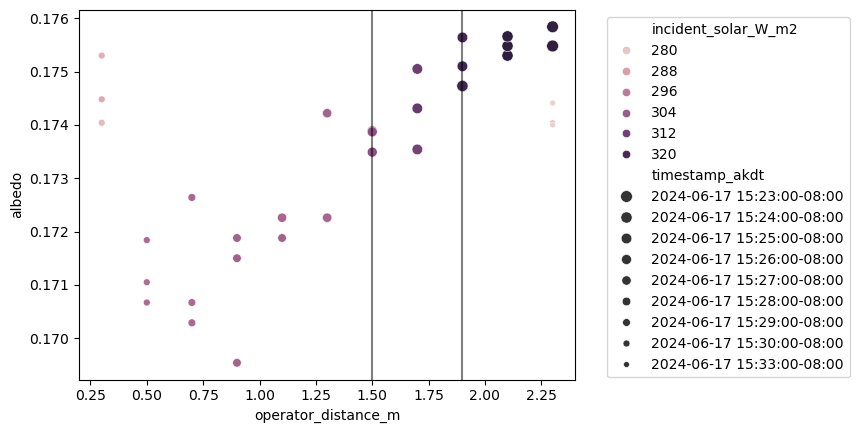

In [36]:
ax = sns.scatterplot(x='operator_distance_m', y='albedo', 
                     hue='incident_solar_W_m2', size='timestamp_akdt', 
                     data=df_unc[(df_unc.operator_pants=='black') & df_unc.notes.isna()])
sns.move_legend(ax, "upper left", bbox_to_anchor=(1.05, 1.0))
ax.axvline(x=1.5, c='k', alpha=0.5)
ax.axvline(x=1.9, c='k', alpha=0.5)


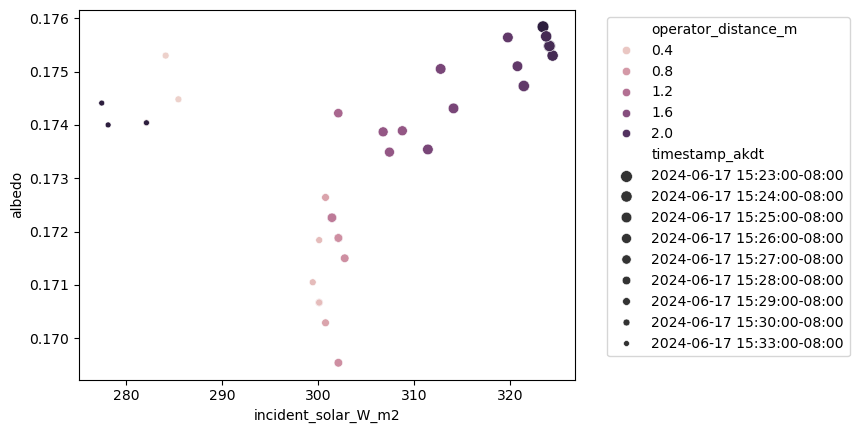

In [40]:
ax = sns.scatterplot(hue='operator_distance_m', y='albedo', 
                     x='incident_solar_W_m2', size='timestamp_akdt', 
                     data=df_unc[(df_unc.operator_pants=='black') & df_unc.notes.isna()])
sns.move_legend(ax, "upper left", bbox_to_anchor=(1.05, 1.0))

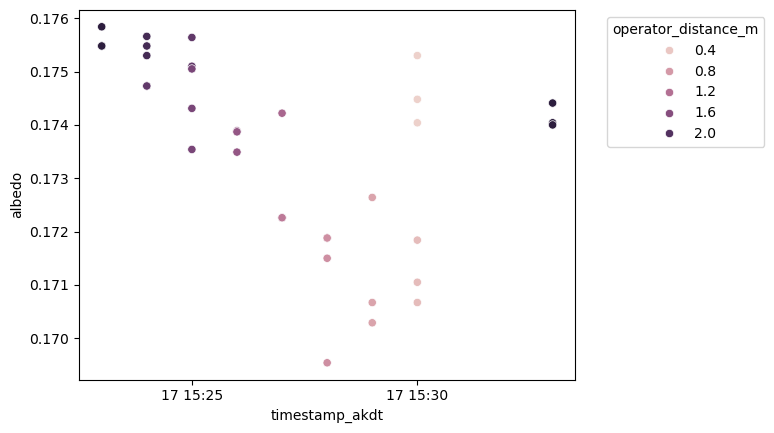

In [38]:
ax = sns.scatterplot(hue='operator_distance_m', y='albedo', x='timestamp_akdt', 
                     data=df_unc[(df_unc.operator_pants=='black') & df_unc.notes.isna()])
sns.move_legend(ax, "upper left", bbox_to_anchor=(1.05, 1.0))

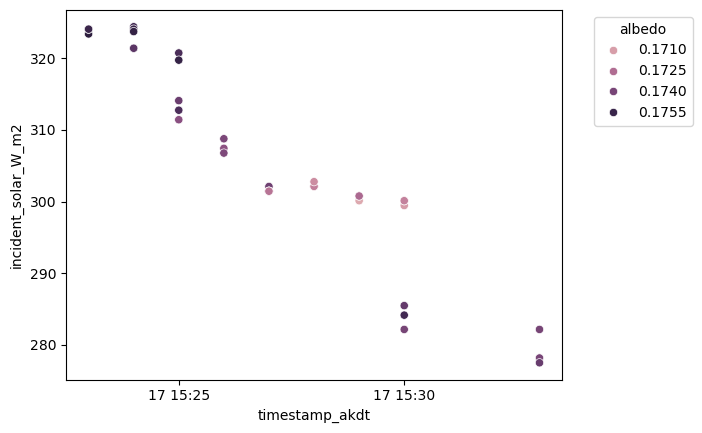

In [39]:
ax = sns.scatterplot(hue='albedo', y='incident_solar_W_m2', x='timestamp_akdt', 
                     data=df_unc[(df_unc.operator_pants=='black') & df_unc.notes.isna()])
sns.move_legend(ax, "upper left", bbox_to_anchor=(1.05, 1.0))

In [48]:
df_unc_2_3m = df_unc[(df_unc.operator_pants=='black') & df_unc.notes.isna() & (df_unc.operator_distance_m==2.3)]
df_unc_2_3m

,timestamp_akdt,incident_solar_W_m2,reflected_solar_W_m2,albedo,site,location,operator_distance_m,operator_pants,repetition,notes
0,2024-06-17 15:23:00-08:00,323.42,56.870,0.17584,beo,uncertainty_test,2.3,black,1.0,NaN
1,2024-06-17 15:23:00-08:00,324.09,56.870,0.17548,beo,uncertainty_test,2.3,black,2.0,NaN
2,2024-06-17 15:23:00-08:00,324.09,56.870,0.17548,beo,uncertainty_test,2.3,black,3.0,NaN
37,2024-06-17 15:33:00-08:00,282.12,49.100,0.17404,beo,uncertainty_test,2.3,black,1.0,NaN
38,2024-06-17 15:33:00-08:00,278.13,48.393,0.17400,beo,uncertainty_test,2.3,black,2.0,NaN
39,2024-06-17 15:33:00-08:00,277.46,48.393,0.17441,beo,uncertainty_test,2.3,black,3.0,NaN


In [54]:
df_unc[(df_unc.operator_pants=='black') & df_unc.notes.isna() & (df_unc.operator_distance_m.isin([1.5, 1.7, 1.9, 2.3]))
    ][['operator_distance_m', 'albedo']].groupby('operator_distance_m').mean()

,albedo
operator_distance_m,
1.5,0.173750
1.7,0.174300
1.9,0.175050
2.3,0.174875


In [53]:
df_unc[df_unc.notes.isna() & (df_unc.operator_distance_m==1.5)
    ][['operator_pants', 'albedo']].groupby('operator_pants').mean()

,albedo
operator_pants,
black,0.17375
green,0.17241


In [61]:
print('hanging datalogger albedo:')
print(df_unc[df_unc.notes.isna() & (df_unc.operator_distance_m==2.3)]['albedo'].mean())
print('holding datalogger albedo:')
print(df_unc[df_unc.notes=="holding datalogger so it doesn't hang"]['albedo'].mean())

hanging datalogger albedo:
0.17487499999999997
holding datalogger albedo:
0.17497666666666667


## Compare with GML and NSA measurements

In [117]:
# Compare arm incident with GML incident
# Shifting the field obs forward 1 minute slightly improves alignment
offset = pd.Timedelta(1, 'min')

df_temp = df_gml.query("incident_solar_W_m2_qc==0")
df_temp.index = df_temp.index.tz_convert('-0800').rename('timestamp_akdt')
df_temp = df_temp[['incident_solar_W_m2', 'incident_bestestimate_W_m2', 'direct_solar_W_m2', 'diffuse_solar_W_m2', 'zen']]
df_temp2 = df.xs(('arm', 'incident_solar_W_m2'), level=('site', 'variable')).droplevel(['location', 'position', 'repetition', 'wavelength'])
df_temp2 = df_temp2.rename(columns={'value': 'salvo_arm_incident'})
df_temp2 = df_temp2.reset_index()
df_temp2['timestamp_akdt'] += offset
df_temp2 = df_temp2.set_index('timestamp_akdt')
df_temp3 = df_nsa.copy()
df_temp3.index = df_temp3.index.tz_convert('-0800').rename('timestamp_akdt')
df_temp3 = df_temp3['BestEstimate_down_short_hemisp'].rename('nsa_incident')

df_comp = df_temp2.join(df_temp)
df_comp = df_comp.join(df_temp3)
df_comp['diff_gml_be'] = df_comp['salvo_arm_incident'] - df_comp['incident_bestestimate_W_m2']
df_comp['diff_nsa'] = df_comp['salvo_arm_incident'] - df_comp['nsa_incident']

df_comp['diff_gml'] = df_comp['salvo_arm_incident'] - df_comp['incident_solar_W_m2']
df_comp['diff_gml_be'] = df_comp['salvo_arm_incident'] - df_comp['incident_bestestimate_W_m2']
df_comp['diff_nsa'] = df_comp['salvo_arm_incident'] - df_comp['nsa_incident']
df_comp['diff_gml_nsa'] = df_comp['incident_bestestimate_W_m2'] - df_comp['nsa_incident']

df_comp['diffuse_frac'] = df_comp['diffuse_solar_W_m2']/df_comp['incident_bestestimate_W_m2']

df_comp['mean_incident_W_m2'] = df_comp.salvo_arm_incident + df_comp.incident_bestestimate_W_m2 + df_comp.nsa_incident


In [118]:
df_comp['diff_gml_be'].describe()

count    628.000000
mean       0.212652
std       36.644248
min     -239.690515
25%       -6.650266
50%        2.900666
75%        8.794934
max      209.964807
Name: diff_gml_be, dtype: float64

In [119]:
df_comp['diff_nsa'].describe()

count    628.000000
mean      -1.420497
std       41.002564
min     -428.670264
25%       -8.826814
50%       -0.777054
75%       10.582272
max      168.489025
Name: diff_nsa, dtype: float64

In [120]:
df_comp['diff_gml_nsa'].describe()

count    628.000000
mean      -1.633150
std       29.829374
min     -208.216921
25%       -6.098053
50%       -1.296730
75%        5.478767
max      198.640625
Name: diff_gml_nsa, dtype: float64

In [121]:
# Median Absolute Deviation
print('Diff NSA Median Absolute Deviation:')
print(df_comp['diff_gml_be'].abs().median())
print('equivalent St. Dev. for normal distribution:')
print(df_comp['diff_gml_be'].abs().median()*1.4826)

Diff NSA Median Absolute Deviation:
7.903755863385783
equivalent St. Dev. for normal distribution:
11.71810844305576


In [122]:
# Median Absolute Deviation
print('Diff GML NSA Median Absolute Deviation:')
print(df_comp['diff_gml_nsa'].abs().median())
print('equivalent St. Dev. for normal distribution:')
print(df_comp['diff_gml_nsa'].abs().median()*1.4826)

Diff GML NSA Median Absolute Deviation:
6.010226363144625
equivalent St. Dev. for normal distribution:
8.91076160599822


Text(0.5, 0, 'salvo-gml incident (W/m2')

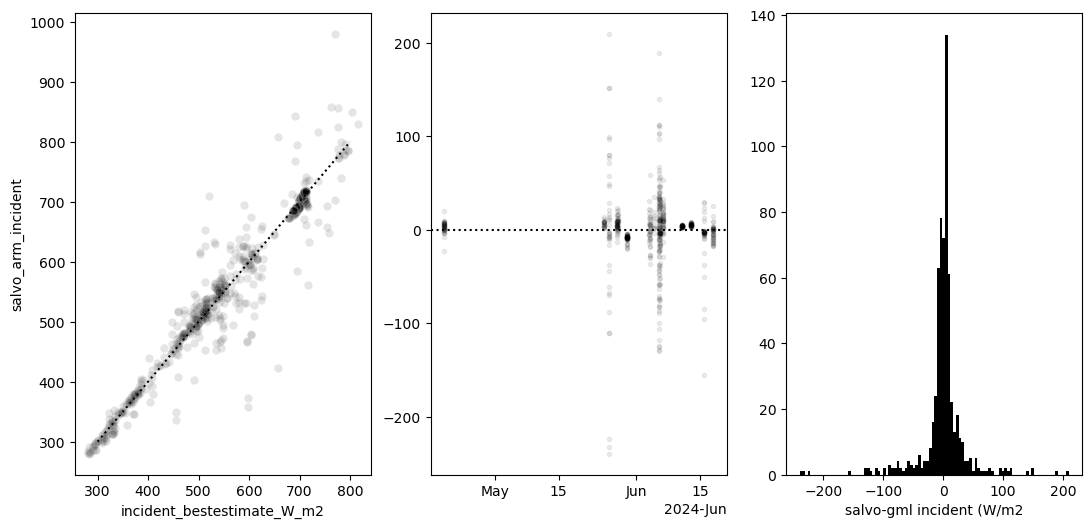

In [123]:
f, axs = plt.subplots(1, 3, figsize=(13, 6))

sns.scatterplot(data=df_comp, x='incident_bestestimate_W_m2', y='salvo_arm_incident', ax=axs[0], alpha=0.1, c='k')
axs[0].plot([300, 800], [300, 800], 'k:')

axs[1].plot(df_comp['diff_gml_be'], marker='.', linestyle='', alpha=0.07, c='k')
axs[1].axhline(y=0, color='k', linestyle=':')

locator = mdates.AutoDateLocator(minticks=3, maxticks=7)
formatter = mdates.ConciseDateFormatter(locator)
axs[1].xaxis.set_major_locator(locator)
axs[1].xaxis.set_major_formatter(formatter)

axs[2].hist(df_comp['diff_gml_be'], bins=100, fc='k')
axs[2].set_xlabel('salvo-gml incident (W/m2')

Text(0.5, 0, 'salvo-nsa incident (W/m2')

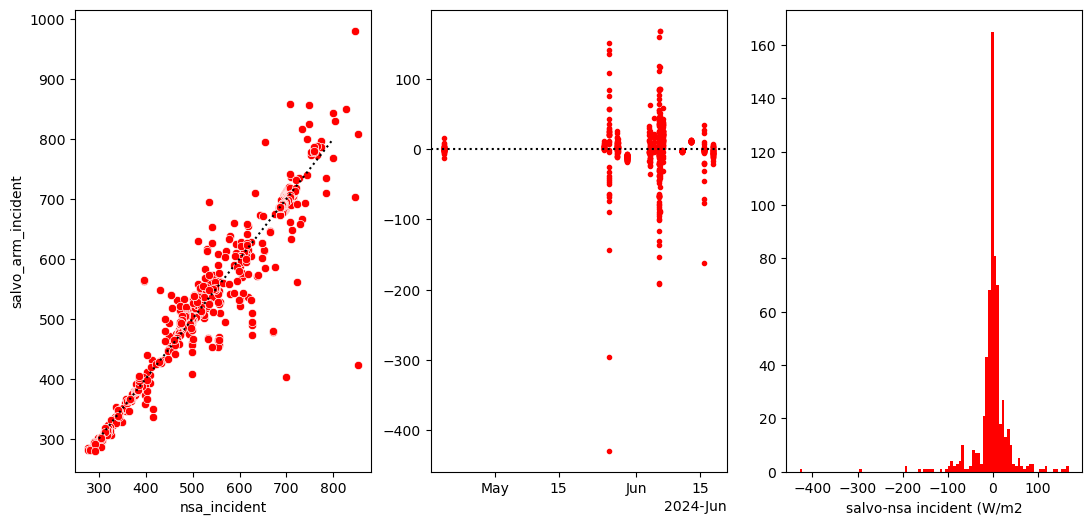

In [124]:
f, axs = plt.subplots(1, 3, figsize=(13, 6))

sns.scatterplot(data=df_comp, x='nsa_incident', y='salvo_arm_incident', ax=axs[0], color='r')
axs[0].plot([300, 800], [300, 800], 'k:')

axs[1].plot(df_comp['diff_nsa'], marker='.', linestyle='', color='r')
axs[1].axhline(y=0, color='k', linestyle=':')

locator = mdates.AutoDateLocator(minticks=3, maxticks=7)
formatter = mdates.ConciseDateFormatter(locator)
axs[1].xaxis.set_major_locator(locator)
axs[1].xaxis.set_major_formatter(formatter)

axs[2].hist(df_comp['diff_nsa'], bins=100, color='r')
axs[2].set_xlabel('salvo-nsa incident (W/m2')

Text(0.5, 0, 'gml-nsa incident (W/m2')

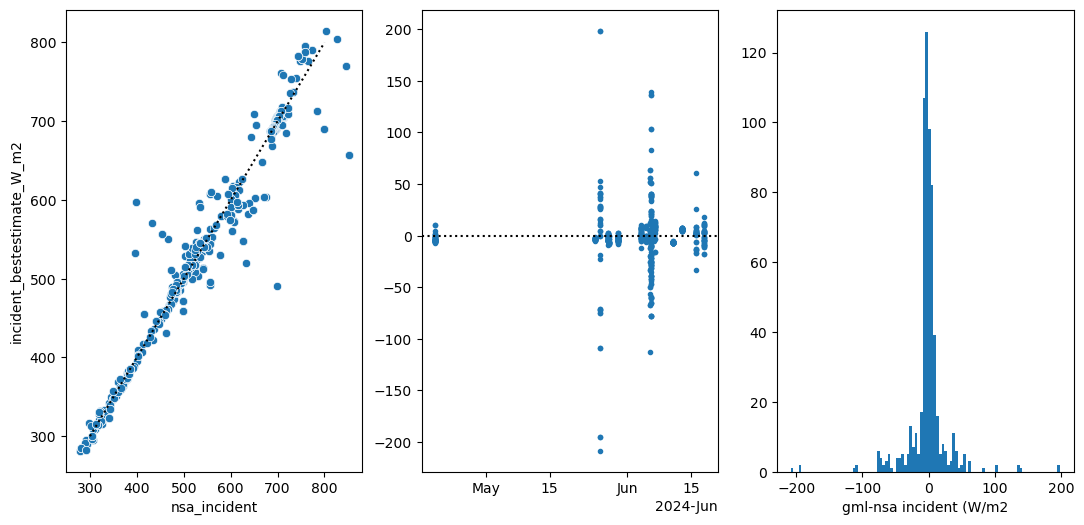

In [125]:
f, axs = plt.subplots(1, 3, figsize=(13, 6))

sns.scatterplot(data=df_comp, x='nsa_incident', y='incident_bestestimate_W_m2', ax=axs[0])
axs[0].plot([300, 800], [300, 800], 'k:')

axs[1].plot(df_comp['diff_gml_nsa'], marker='.', linestyle='')
axs[1].axhline(y=0, color='k', linestyle=':')

locator = mdates.AutoDateLocator(minticks=3, maxticks=7)
formatter = mdates.ConciseDateFormatter(locator)
axs[1].xaxis.set_major_locator(locator)
axs[1].xaxis.set_major_formatter(formatter)

axs[2].hist(df_comp['diff_gml_nsa'], bins=100)
axs[2].set_xlabel('gml-nsa incident (W/m2')

In [126]:
df_comp['diff_gml_nsa'].groupby(df_comp.index.date).std()

2024-04-19     3.938224
2024-05-24     1.094270
2024-05-25    83.038427
2024-05-27     3.015690
2024-05-29     2.328462
2024-06-03     4.713886
2024-06-04     5.507422
2024-06-05    41.055364
2024-06-06     6.452998
2024-06-10     0.471615
2024-06-12     0.957541
2024-06-15    13.210465
2024-06-17     8.311048
Name: diff_gml_nsa, dtype: float64

In [127]:
# May 25, June 5, and June 15 were partly cloudy with highly variable sky conditions, let's exclude those from the comparison

In [128]:
df_comp_stablesky = df_comp[(df_comp.index.date!=datetime.date(2024, 5, 25)) 
                            & (df_comp.index.date!=datetime.date(2024, 6, 5))
                            & (df_comp.index.date!=datetime.date(2024, 6, 15))]

In [129]:
df_comp_stablesky['diff_gml_be'].describe()

count    390.000000
mean       2.256797
std       10.573556
min      -36.685276
25%       -4.283895
50%        3.509558
75%        7.039769
max       58.974658
Name: diff_gml_be, dtype: float64

In [130]:
df_comp_stablesky['diff_nsa'].describe()

count    390.000000
mean       1.655247
std       12.248450
min      -34.971416
25%       -5.297762
50%       -0.040605
75%        9.100570
max       62.541526
Name: diff_nsa, dtype: float64

In [131]:
df_comp_stablesky['diff_gml_nsa'].describe()

count    390.000000
mean      -0.601550
std        5.797115
min      -17.653332
25%       -5.029003
50%       -1.682513
75%        4.323938
max       18.285956
Name: diff_gml_nsa, dtype: float64

In [164]:
# Try excluding measurements where the proportional difference between the gml and nsa incident exceeds a threshold
diff_gml_nsa_th = 0.01

df_comp_th = df_comp[((df_comp.diff_gml_nsa*2)/(df_comp.incident_bestestimate_W_m2+df_comp.nsa_incident)).abs()<diff_gml_nsa_th]

print(df_comp_th.size/df_comp.size)

0.4984076433121019


In [165]:
df_comp_th['diff_gml_be'].describe()

count    313.000000
mean      -0.668092
std       16.539927
min     -155.426608
25%       -5.663225
50%        1.840076
75%        4.777454
max       79.563615
Name: diff_gml_be, dtype: float64

In [166]:
df_comp_th['diff_nsa'].describe()

count    313.000000
mean      -1.346851
std       17.133552
min     -161.939873
25%       -6.736166
50%       -1.872197
75%        4.807281
max       84.104375
Name: diff_nsa, dtype: float64

In [167]:
df_comp_th['diff_gml_nsa'].describe()

count    313.000000
mean      -0.678759
std        3.828804
min       -7.053619
25%       -3.631111
50%       -0.949991
75%        2.012765
max        6.805230
Name: diff_gml_nsa, dtype: float64

In [168]:
df_comp['diff_gml_be'].abs().median()

7.903755863385783

In [169]:
df_comp_stablesky['diff_gml_be'].abs().median()

6.2326013752403355

In [170]:
df_comp_th['diff_gml_be'].abs().median()

5.139613946540749

In [171]:
df_comp['diff_nsa'].abs().median()

9.645756835937505

In [172]:
df_comp_stablesky['diff_nsa'].abs().median()

7.226566162109378

In [173]:
df_comp_th['diff_nsa'].abs().median()

5.259934082031236

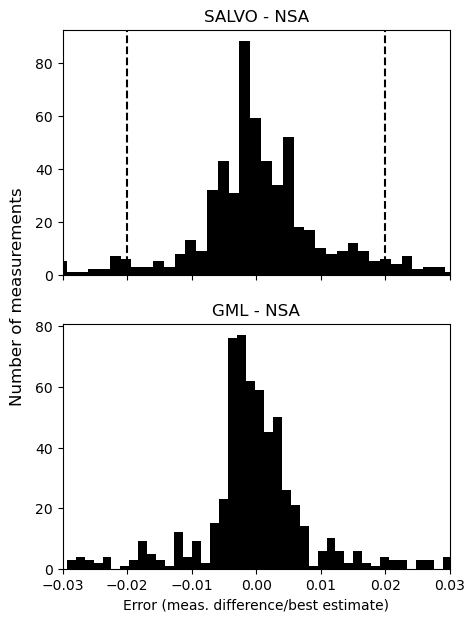

In [174]:
# Create figure comparing normalized incident distributions
f, axs = plt.subplots(2, 1, sharex=True, figsize=(5, 7))

axs[0].hist(df_comp['diff_nsa']/df_comp['mean_incident_W_m2'], bins=200, color='k')
axs[0].axvline(x=0.02, c='k', linestyle='--')
axs[0].axvline(x=-0.02, c='k', linestyle='--')
axs[0].set_title('SALVO - NSA')

axs[1].hist(df_comp['diff_gml_nsa']/df_comp['mean_incident_W_m2'], bins=200, color='k')
axs[1].set_xlim([-0.03, 0.03])
axs[1].set_title('GML - NSA')

axs[1].set_xlabel('Error (meas. difference/best estimate)')
f.supylabel('Number of measurements')
f.savefig(os.path.join('..', 'figures', 'salvo_arm_inc_err.png'), bbox_inches='tight')

In [181]:
(df_comp['diff_gml_be']/df_comp['mean_incident_W_m2']).abs().median()

0.0045303524916026185

In [179]:
(df_comp['diff_gml_nsa']/df_comp['mean_incident_W_m2']).abs().median()

0.0033231483302630545

In [185]:
var_gml_ratio = ((df_comp['diff_gml_be']/df_comp['mean_incident_W_m2']).abs().median()*1.4826)**2
var_gml_nsa_ratio = ((df_comp['diff_gml_nsa']/df_comp['mean_incident_W_m2']).abs().median()*1.4826)**2

print('Diff GML Best Estimate implied variance from MAD:')
print(var_gml_ratio)
print('Diff GML-NSA implied variance from MAD:')
print(var_gml_nsa_ratio)

print('STD of residual:')
std_resid = (var_gml_ratio - var_gml_nsa_ratio)**.5
print(std_resid)

print('Est. STD of albedo:')
print(std_resid*(2)**.5)

Diff GML Best Estimate implied variance from MAD:
4.5114067004446197e-05
Diff GML-NSA implied variance from MAD:
2.4274340796227828e-05
STD of residual:
0.004565054896517496
Est. STD of albedo:
0.00645596254763275


In [186]:
df_comp['diff_gml_be'].mean()

0.21265219273213876

In [187]:
df_comp['diff_nsa'].mean()

-1.4204973607154414

In [188]:
df_comp['diff_gml_nsa'].mean()

-1.63314955344758

## Explore repeatability

In [217]:
df_date_akdt = df.reset_index()
df_date_akdt['date_akdt'] = df.timestamp_akdt.dt.date

idx_repeats = pd.MultiIndex.from_frame(
    df.index[(df.reset_index().repetition==2).values].to_frame(
    ).reset_index(drop=True).drop(
    columns=['timestamp_akdt','repetition','wavelength','variable']))

In [227]:
df_date_akdt = df.reset_index().drop(columns='wavelength')
df_date_akdt['date_akdt'] = df_date_akdt.timestamp_akdt.dt.date
df_date_akdt = df_date_akdt.set_index(['date_akdt', 'site', 'location', 'position', 'variable'])

idx_repeats = df_date_akdt.index[df_date_akdt.repetition==2.0]
df_repeats = df_date_akdt.loc[idx_repeats]

In [229]:
df_compare_repeats = pd.merge(df_repeats, df_repeats, how='cross')
df_compare_repeats = df_compare_repeats[df_compare_repeats.repetition_x

,timestamp_akdt_x,repetition_x,value_x,timestamp_akdt_y,repetition_y,value_y
0,2024-04-17 15:51:00-08:00,1.0,414.150000,2024-04-17 15:51:00-08:00,1.0,414.150000
1,2024-04-17 15:51:00-08:00,1.0,414.150000,2024-04-17 15:52:00-08:00,2.0,416.390000
2,2024-04-17 15:51:00-08:00,1.0,414.150000,2024-04-17 15:56:00-08:00,3.0,407.440000
3,2024-04-17 15:51:00-08:00,1.0,414.150000,2024-04-17 16:46:00-08:00,1.0,389.020000
4,2024-04-17 15:51:00-08:00,1.0,414.150000,2024-04-17 16:48:00-08:00,2.0,381.190000
...,...,...,...,...,...,...
1218811,2024-06-18 14:15:00-08:00,2.0,0.203077,2024-06-18 14:06:00-08:00,2.0,0.608334
1218812,2024-06-18 14:15:00-08:00,2.0,0.203077,2024-06-18 14:07:00-08:00,1.0,0.570236
1218813,2024-06-18 14:15:00-08:00,2.0,0.203077,2024-06-18 14:09:00-08:00,2.0,0.567810
1218814,2024-06-18 14:15:00-08:00,2.0,0.203077,2024-06-18 14:14:00-08:00,1.0,0.201422


In [230]:
help(pd.merge)

Help on function merge in module pandas.core.reshape.merge:

merge(left: 'DataFrame | Series', right: 'DataFrame | Series', how: 'MergeHow' = 'inner', on: 'IndexLabel | AnyArrayLike | None' = None, left_on: 'IndexLabel | AnyArrayLike | None' = None, right_on: 'IndexLabel | AnyArrayLike | None' = None, left_index: 'bool' = False, right_index: 'bool' = False, sort: 'bool' = False, suffixes: 'Suffixes' = ('_x', '_y'), copy: 'bool | None' = None, indicator: 'str | bool' = False, validate: 'str | None' = None) -> 'DataFrame'
    Merge DataFrame or named Series objects with a database-style join.

    A named Series object is treated as a DataFrame with a single named column.

    The join is done on columns or indexes. If joining columns on
    columns, the DataFrame indexes *will be ignored*. Otherwise if joining indexes
    on indexes or indexes on a column or columns, the index will be passed on.
    When performing a cross merge, no column specifications to merge on are
    allowed.

  

In [214]:
help(pd.DataFrame)

Help on class DataFrame in module pandas.core.frame:

class DataFrame(pandas.core.generic.NDFrame, pandas.core.arraylike.OpsMixin)
 |  DataFrame(data=None, index: 'Axes | None' = None, columns: 'Axes | None' = None, dtype: 'Dtype | None' = None, copy: 'bool | None' = None) -> 'None'
 |
 |  Two-dimensional, size-mutable, potentially heterogeneous tabular data.
 |
 |  Data structure also contains labeled axes (rows and columns).
 |  Arithmetic operations align on both row and column labels. Can be
 |  thought of as a dict-like container for Series objects. The primary
 |  pandas data structure.
 |
 |  Parameters
 |  ----------
 |  data : ndarray (structured or homogeneous), Iterable, dict, or DataFrame
 |      Dict can contain Series, arrays, constants, dataclass or list-like objects. If
 |      data is a dict, column order follows insertion-order. If a dict contains Series
 |      which have an index defined, it is aligned by its index. This alignment also
 |      occurs if data is a Se

In [231]:
1 /= 1

SyntaxError: 'literal' is an illegal expression for augmented assignment (1671045387.py, line 1)